# Drift vs Advanced Drift

The standard `drift_wavefront` function honors the original grid spacing of the wavefront. If the wavefront curvature is approximatly known, the `drift_wavefront_advanced` function can use this to resize the grid appropriately so that any expanding spots remain well within the grid.

In [1]:
from pmd_beamphysics import Wavefront
from pmd_beamphysics.wavefront.propagators import (
    drift_wavefront,
    drift_wavefront_advanced,
)
from pmd_beamphysics.units import Z0, c_light
import numpy as np

import matplotlib.pyplot as plt

# Gaussian pulse 

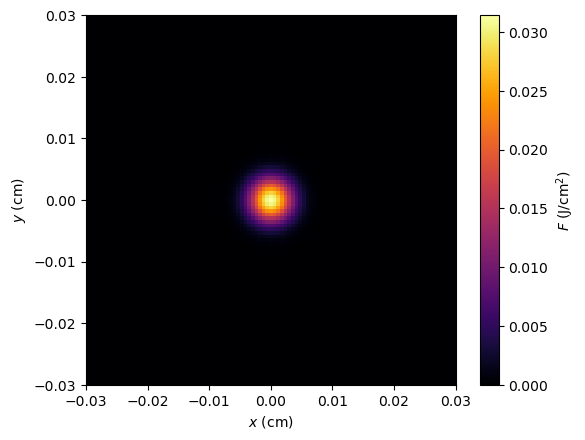

In [2]:
wavelength = 1.2227e-10
w0 = 50e-6
sigma0 = w0 / 2  # RMS beam size at waist
zR = np.pi * w0**2 / wavelength

W = Wavefront.from_gaussian(
    shape=(101, 101, 1368),
    dx=6e-6,
    dy=6e-6,
    dz=1.46724e-09,
    wavelength=wavelength,
    sigma0=sigma0,
    energy=1.2345e-6,
)

W.plot_fluence()

## Checking the total Energy in the W object

In [3]:
W.energy

np.float64(1.2345000000014734e-06)

## Propagate to 420 meters

This is problematic:

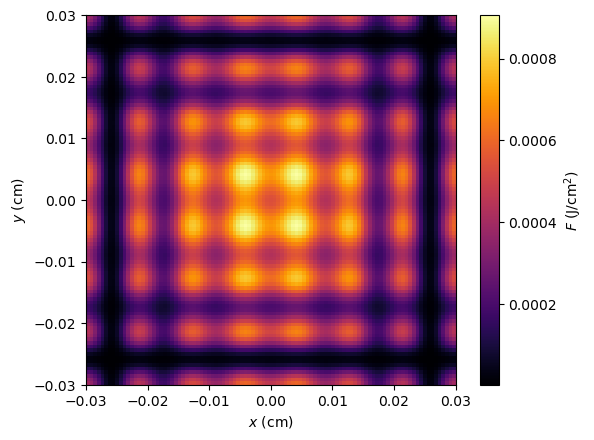

In [4]:
W1 = drift_wavefront(W, 420)
W1.plot_fluence()

## Advanced propagator 

With 

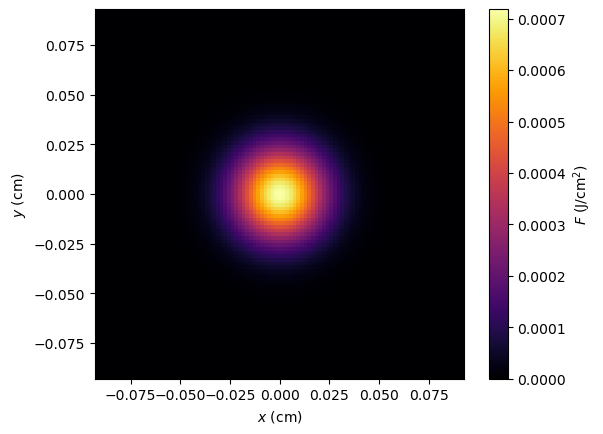

In [5]:
W2 = drift_wavefront_advanced(W, 420, curvature=1 / 200)
W2.plot_fluence()

In [6]:
W2.energy

np.float64(1.2345000000014747e-06)

## Check energy

In [7]:
W2.energy

np.float64(1.2345000000014747e-06)

## Phase errors

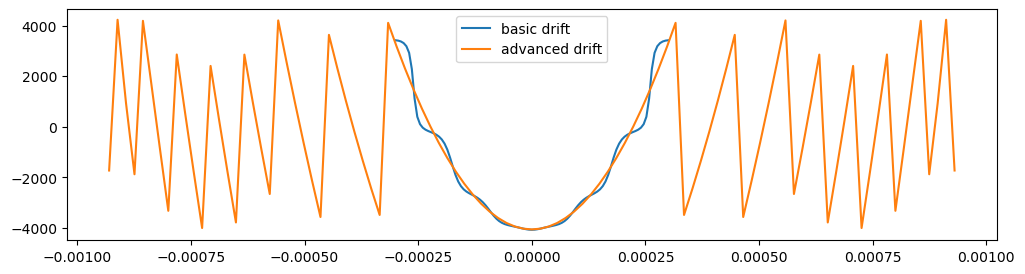

In [8]:
plt.figure(figsize=(12, 3))
phase1 = np.sum(np.angle(W1.Ex), axis=2)[:, 51]
phase2 = np.sum(np.angle(W2.Ex), axis=2)[:, 51]

plt.plot(W1.xvec, phase1, label="basic drift")
plt.plot(W2.xvec, phase2, label="advanced drift")
plt.legend()

## Checking Gaussian beam propagation

In [9]:
%%time
Zlist = np.linspace(0, 1000, 20)
Wlist1 = [drift_wavefront(W, z) for z in Zlist]

Wlist2 = [drift_wavefront_advanced(W, z, curvature=1 / 40) for z in Zlist]

sizes1 = np.array([w.sigma_x for w in Wlist1])
sizes2 = np.array([w.sigma_x for w in Wlist2])

CPU times: user 58.9 s, sys: 6.83 s, total: 1min 5s
Wall time: 1min 5s


In [10]:
energy1 = np.array([w.energy for w in Wlist1])
energy2 = np.array([w.energy for w in Wlist2])

In [11]:
np.sum(np.abs(Wlist2[2].Ex) ** 2) * Wlist2[2].dx * Wlist2[2].dy * Wlist2[2].dz / (
    2 * Z0 * c_light
)

np.float64(1.234500000000002e-06)

In [12]:
sigma_x0 = W.sigma_x

expected_w = sigma_x0 * np.sqrt(1 + (Zlist / zR) ** 2)

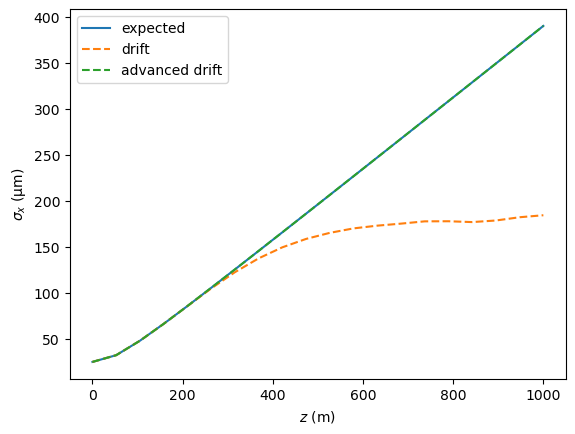

In [13]:
fig, ax = plt.subplots()
ax.plot(Zlist, 1e6 * expected_w, label="expected")
ax.plot(Zlist, 1e6 * sizes1, "--", label="drift")
ax.plot(Zlist, 1e6 * sizes2, "--", label="advanced drift")
ax.set_xlabel(r"$z$ (m)")

ax.set_ylabel(r"$\sigma_x$ (µm)")
plt.legend()

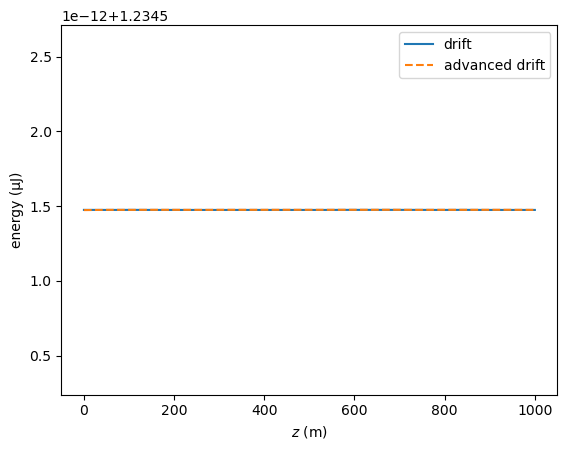

In [14]:
fig, ax = plt.subplots()
# ax.plot(Zlist, 1e6 * expected_w, label="expected")
ax.plot(Zlist, 1e6 * energy1, "-", label="drift")
ax.plot(Zlist, 1e6 * energy2, "--", label="advanced drift")
ax.set_xlabel(r"$z$ (m)")

ax.set_ylabel(r"energy (µJ)")
plt.legend()

# K-space 

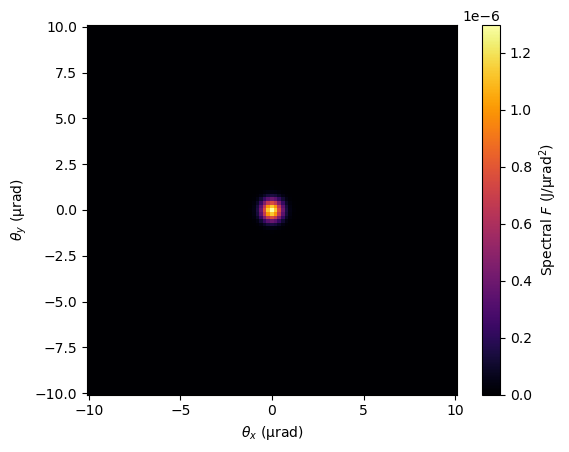

In [15]:
Wk = W.to_kspace()
Wk.plot_spectral_intensity()

In [16]:
sigma_thetax1 = np.array([float(w.to_kspace().sigma_thetax) for w in Wlist1])
sigma_thetax2 = np.array([float(w.to_kspace().sigma_thetax) for w in Wlist2])

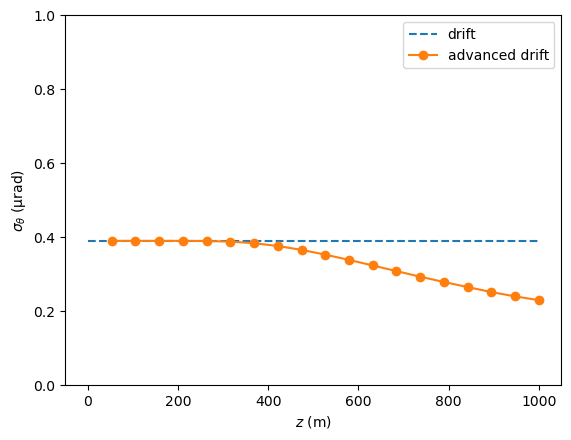

In [17]:
fig, ax = plt.subplots()
ax.plot(Zlist, 1e6 * sigma_thetax1, "--", label="drift")
ax.plot(Zlist[1:], 1e6 * sigma_thetax2[1:], "o-", label="advanced drift")
ax.set_xlabel(r"$z$ (m)")

ax.set_ylabel(r"$\sigma_\theta$ (µrad)")

ax.set_ylim(0, 1)
plt.legend()

# Check energy conservation

In [18]:
kenergy1 = np.array([float(w.to_kspace().energy) for w in Wlist1])
kenergy2 = np.array([float(w.to_kspace().energy) for w in Wlist2])

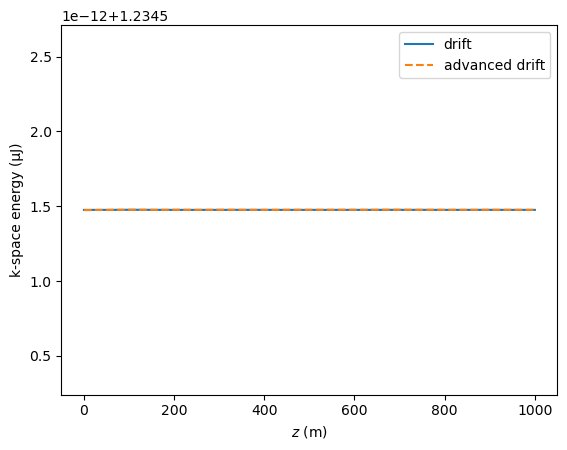

In [19]:
fig, ax = plt.subplots()
# ax.plot(Zlist, 1e6 * expected_w, label="expected")
ax.plot(Zlist, 1e6 * kenergy1, "-", label="drift")
ax.plot(Zlist, 1e6 * kenergy2, "--", label="advanced drift")
ax.set_xlabel(r"$z$ (m)")

ax.set_ylabel(r"k-space energy (µJ)")
plt.legend()